In [1]:
using OrdinaryDiffEq
using CairoMakie

In [2]:
function clamped_loc(x, L)
    return mod(x + L/2, L) - L/2
end

function gaussian(x, y, L)
    cx = clamped_loc(x, L)
    cy = clamped_loc(y, L)
    ix = floor(Int, (x + L/2)/L)
    iy = floor(Int, (y + L/2)/L)
    sign = (2 * mod(ix, 2) - 1) * (2 * mod(iy, 2) - 1)
    return @. sign * exp.(-(cx^2 + cy^2))
end

function ψ(x, y, t, p)
    return @. p.scale * gaussian(x, y, p.L)
end

function u(x, y, t, p)
    cy = clamped_loc.(y, p.L)
    return p.scale * 2*cy.*gaussian.(x, y, p.L)
end

function v(x, y, t, p)
    cx = clamped_loc.(x, p.L)
    return -p.scale * 2*cx.*gaussian.(x, y, p.L)
end

function ∂u∂x(x, y, t, p)
    cx = clamped_loc.(x, p.L)
    cy = clamped_loc.(y, p.L)
    return -p.scale * 4*cx.*cy.*gaussian.(x, y, p.L)
end

function ∂u∂y(x, y, t, p)
    cy = clamped_loc.(y, p.L)
    return p.scale * (2 .- 4*cy.^2).*gaussian.(x, y, p.L)
end

function ∂v∂x(x, y, t, p)
    cx = clamped_loc.(x, p.L)
    return p.scale * (4*cx.^2 .- 2).*gaussian.(x, y, p.L)
end

function ∂v∂y(x, y, t, p)
    cx = clamped_loc.(x, p.L)
    cy = clamped_loc.(y, p.L)
    return p.scale * 4*cx.*cy.*gaussian.(x, y, p.L)
end

∂v∂y (generic function with 1 method)

In [3]:
x = 0.2
y = 0.4
t = 0.0
params = (A = 0.2, scale=0.2, L=2π)
vorticity     = ∂v∂x(x, y, t, params) - ∂u∂y(x, y, t, params)
shear_strain  = ∂v∂x(x, y, t, params) + ∂u∂y(x, y, t, params)
normal_strain = ∂u∂x(x, y, t, params) - ∂v∂y(x, y, t, params)
divergence    = ∂u∂x(x, y, t, params) + ∂v∂y(x, y, t, params)
println("Divergence:    ", divergence)
println("Normal strain: ", normal_strain)
println("Shear strain:  ", shear_strain)
println("Vorticity:     ", vorticity)

Divergence:    0.0
Normal strain: -0.10479753639398175
Shear strain:  -0.07859815229548611
Vorticity:     -0.5239876819699083


In [4]:
function dispersion_relation(k1, k2, params)
    return @. sqrt(params.f^2 + params.gH*(k1^2 + k2^2))
end

function dxkdt!(dxk, xk, p, t)
    x = @views xk[:, 1]
    y = @views xk[:, 2]
    k = @views xk[:, 3]
    l = @views xk[:, 4]

    ω = dispersion_relation(k, l, p)
    Cg_x = @. p.gH * k / sqrt(p.f^2 + p.gH * (k^2 + l^2))
    Cg_y = @. p.gH * l / sqrt(p.f^2 + p.gH * (k^2 + l^2))

    dx = @views dxk[:, 1]
    dy = @views dxk[:, 2]
    dk = @views dxk[:, 3]
    dl = @views dxk[:, 4]

    u_packet = u(x, y, t, p)
    v_packet = v(x, y, t, p)
    ux = ∂u∂x(x, y, t, p)
    uy = ∂u∂y(x, y, t, p)
    vx = ∂v∂x(x, y, t, p)
    vy = ∂v∂y(x, y, t, p)

    dx .= u_packet + Cg_x
    dy .= v_packet + Cg_y
    dk .= @. -ux * k - vx * l
    dl .= @. -uy * k - vy * l
end

dxkdt! (generic function with 1 method)

In [5]:
initial_x0 = -4
Npackets = 101

L = 5
scale = 0.5
gH = 8e0
f = 1.0

x0 = zeros(Npackets) .+ initial_x0
range = (0:(Npackets-1)) / (Npackets - 1)
y0 = @. (2 * range - 1) * abs(initial_x0)
k0 = zeros(Npackets) .+ 10.0
l0 = zeros(Npackets)
u0 = hcat(x0, y0, k0, l0)
ode_params = (; L, scale, gH, f) # Semi-colon to create a named tuple with current variable names
prob = ODEProblem(dxkdt!, u0, (0.0f0, 250.0f0), ode_params)

sol = solve(prob, Vern7(), reltol = 1e-7, abstol = 1e-7, saveat = 0.1);

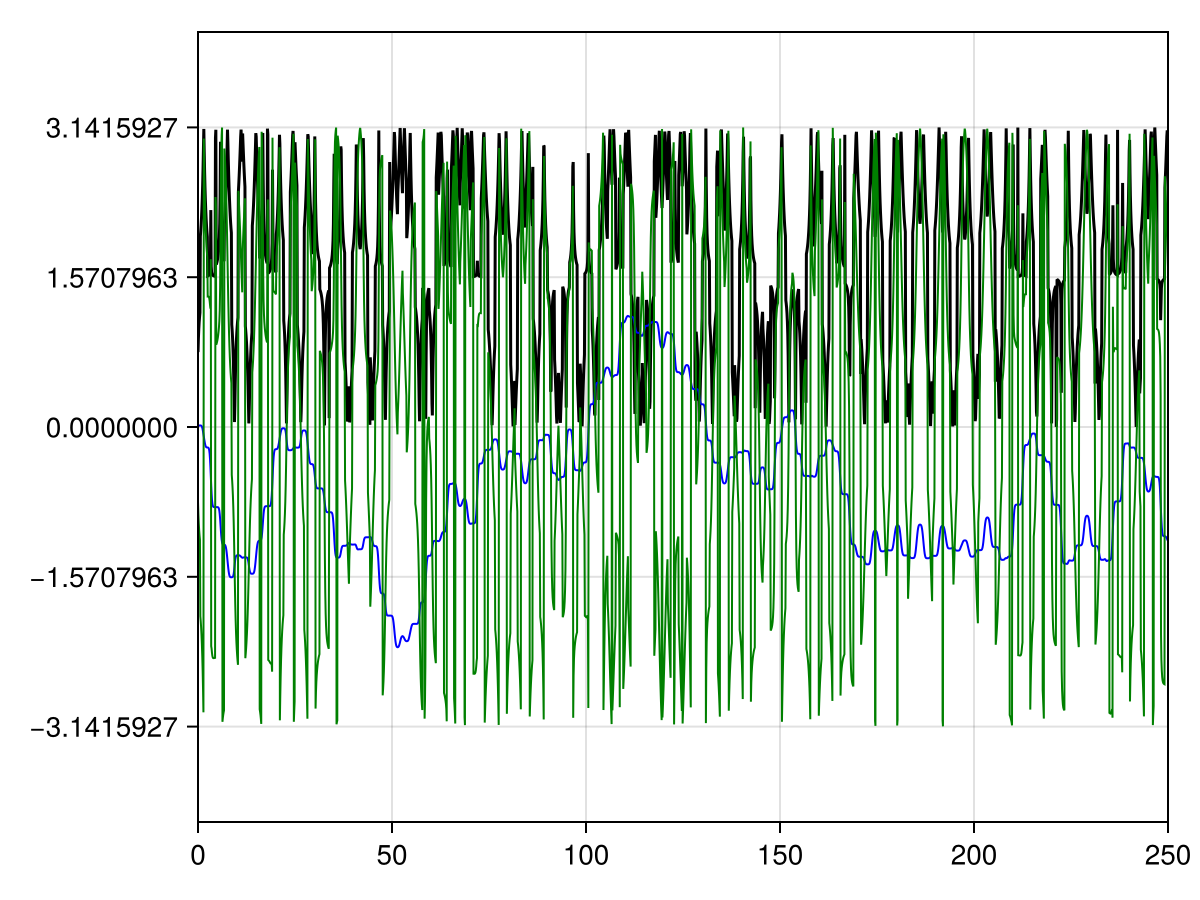

In [6]:
x_sol = sol[:,1,:]'
y_sol = sol[:,2,:]'
k_sol = sol[:,3,:]'
l_sol = sol[:,4,:]'
t_sol = sol.t
u_sol = u.(x_sol, y_sol, t_sol, Ref(ode_params))
v_sol = v.(x_sol, y_sol, t_sol, Ref(ode_params))

ω_sol = dispersion_relation.(k_sol, l_sol, Ref(ode_params))
doppler_shift = u_sol .* k_sol + v_sol .* l_sol
wave_mag = sqrt.(l_sol.^2 + k_sol.^2)
vel_mag = sqrt.(u_sol.^2 + v_sol.^2)
dop_angle = acos.(max.(min.(doppler_shift ./ wave_mag ./ vel_mag, 1), -1))
wave_angle = atan.(l_sol, k_sol)
pos_angle = atan.(y_sol, x_sol)
vel_angle = atan.(v_sol, u_sol)


f = Figure()
ax = Axis(f[1,1]; limits=((0, sol.t[end]), (-π-1, π+1)),
    yticks=[-π, -π/2, 0, π/2, π])
for i=1:1
    lines!(ax, sol.t, dop_angle[:,i], color=:black)
    lines!(ax, sol.t, wave_angle[:,i], color=:blue, linewidth=1)
    #lines!(ax, sol.t, pos_angle[:,i], color=:red, linewidth=1)
    lines!(ax, sol.t, vel_angle[:,i], color=:green, linewidth=1)
end
#lines!(ax, sol.t, doppler_shift)
#lines!(ax, sol.t, sol[3,:].^2 + sol[4,:].^2)
#lines!(ax, sol.t, sol[1,:])
f

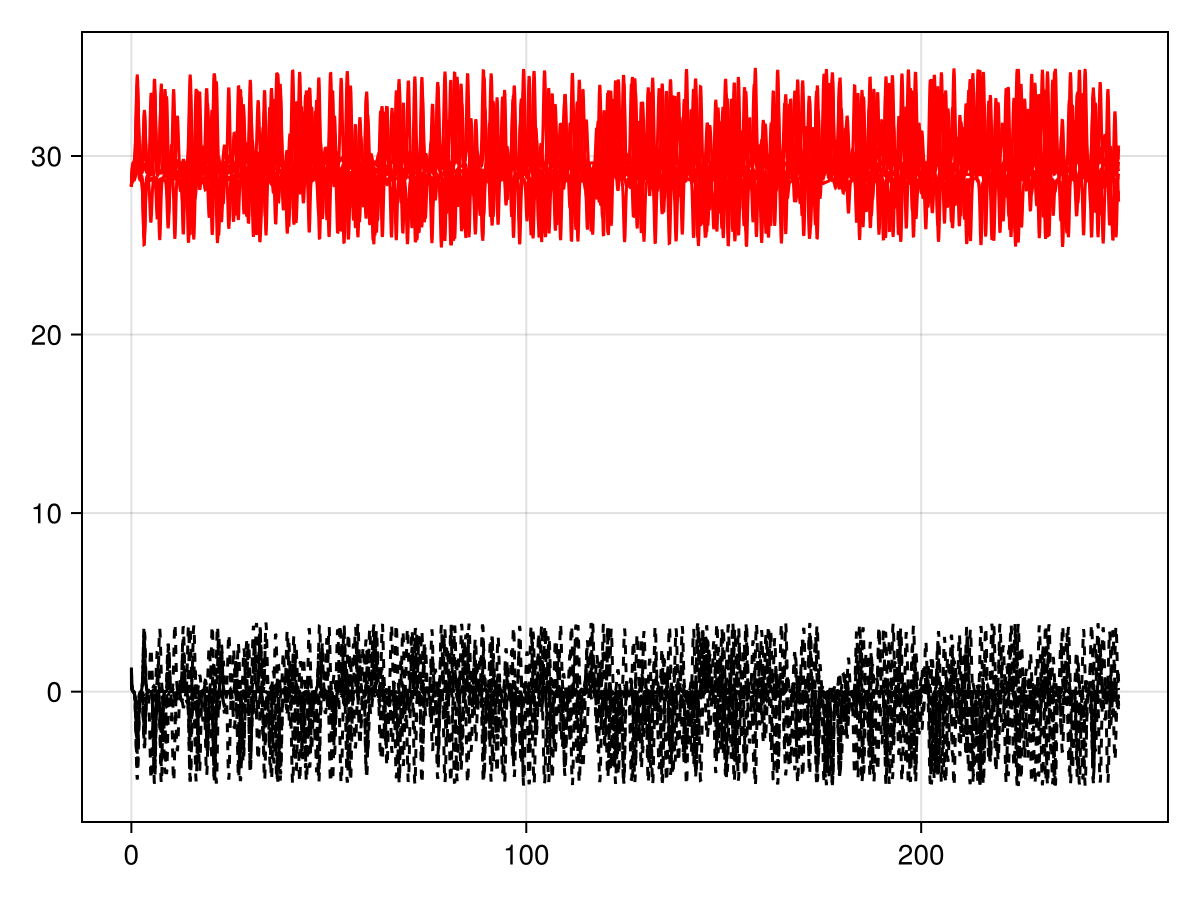

In [7]:
f2 = Figure()
ax = Axis(f2[1,1])
for i=1:10
    lines!(ax, sol.t, ω_sol[:,i], color=:red)
    lines!(ax, sol.t, doppler_shift[:,i], color=:black, linestyle=:dash)
    #lines!(ax, sol.t, wave_mag[:,i] .* vel_mag[:,i], color=:green)
end

f2

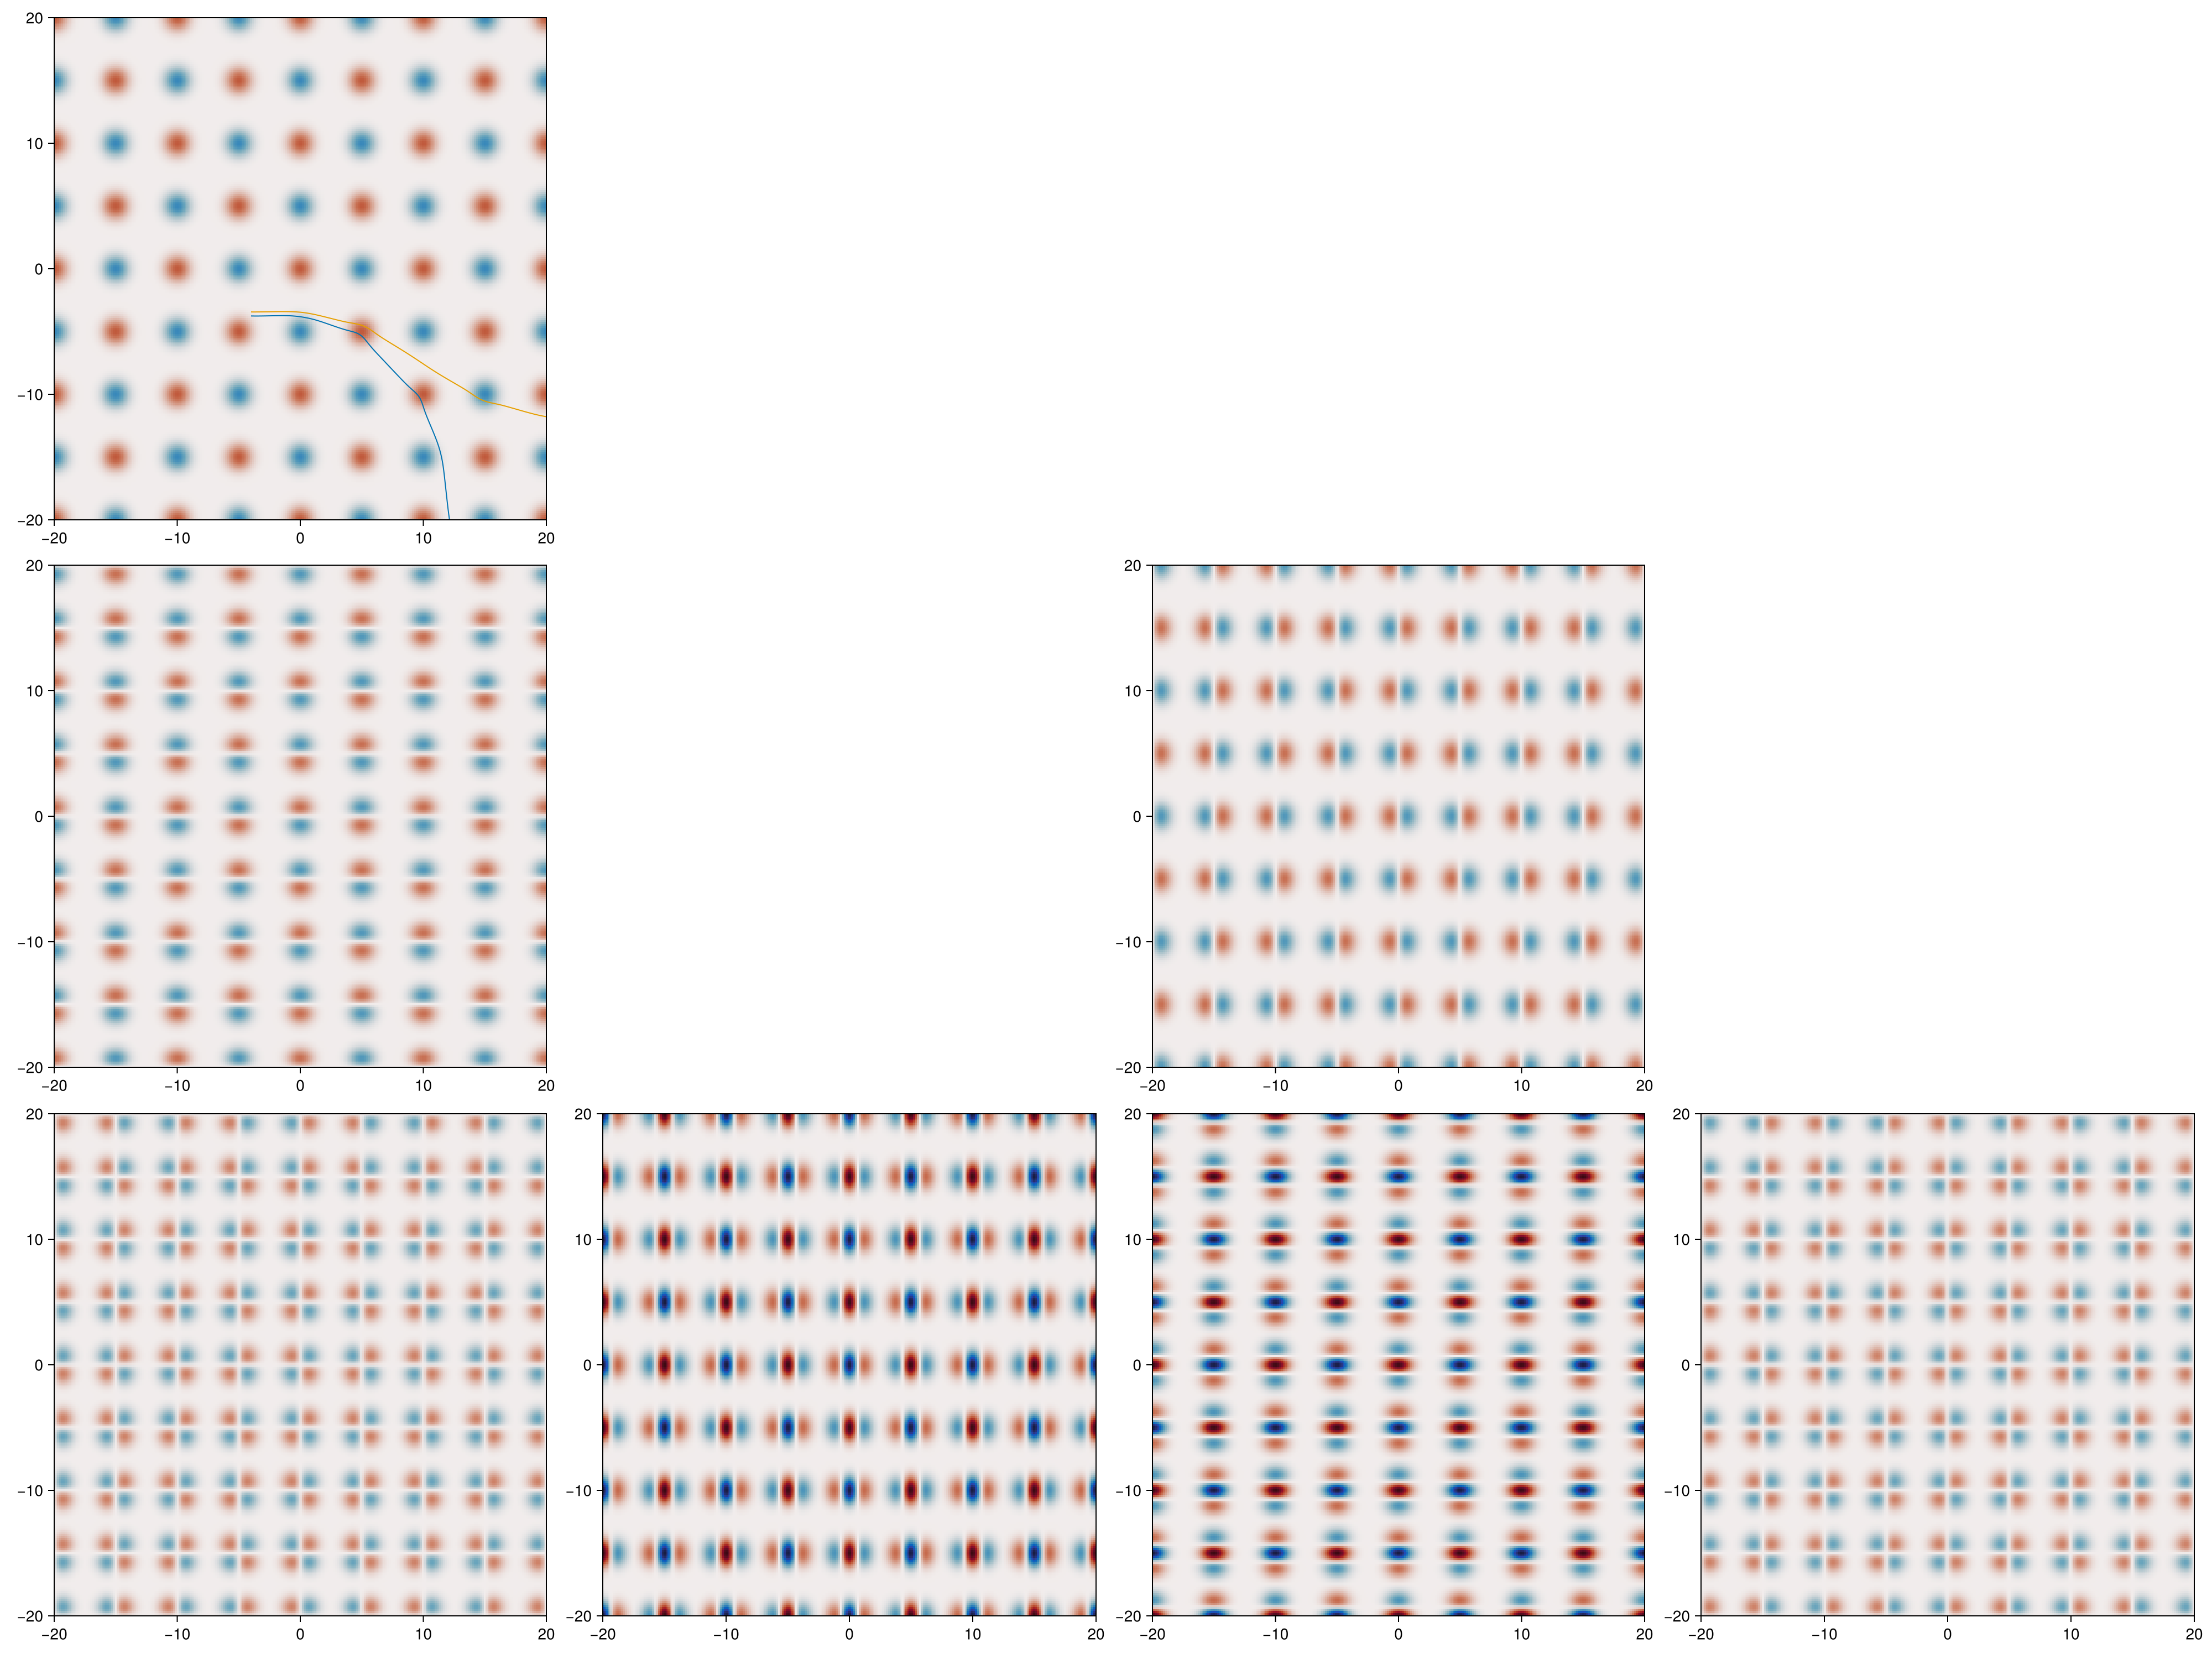

In [8]:
resolution = 256
range = (0:(resolution-1)) ./ (resolution - 1)
x = @. (2 * range - 1) * (5 * abs(initial_x0))
y = x'


ax_opts = (colormap=:balance, colorrange=(-1, 1))
fig = Figure(size=(2000, 1500))
ax11 = Axis(fig[1,1]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax11, x[:], y[:], ψ.(x, y, 0, Ref(ode_params)); ax_opts...)

ax12 = Axis(fig[2,1]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax12, x[:], y[:], u.(x, y, 0, Ref(ode_params)); ax_opts...)
ax23 = Axis(fig[2,3]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax23, x[:], y[:], v.(x, y, 0, Ref(ode_params)); ax_opts...)

ax31 = Axis(fig[3,1]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax31, x[:], y[:], ∂u∂x.(x, y, 0, Ref(ode_params)); ax_opts...)
ax32 = Axis(fig[3,2]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax32, x[:], y[:], ∂v∂x.(x, y, 0, Ref(ode_params)); ax_opts...)
ax33 = Axis(fig[3,3]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax33, x[:], y[:], ∂u∂y.(x, y, 0, Ref(ode_params)); ax_opts...)
ax34 = Axis(fig[3,4]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax34, x[:], y[:], ∂v∂y.(x, y, 0, Ref(ode_params)); ax_opts...)



idx = 4
lines!(ax11, x_sol[:,idx], y_sol[:,idx], linewidth=1)
idx = 8
lines!(ax11, x_sol[:,idx], y_sol[:,idx], linewidth=1)

fig

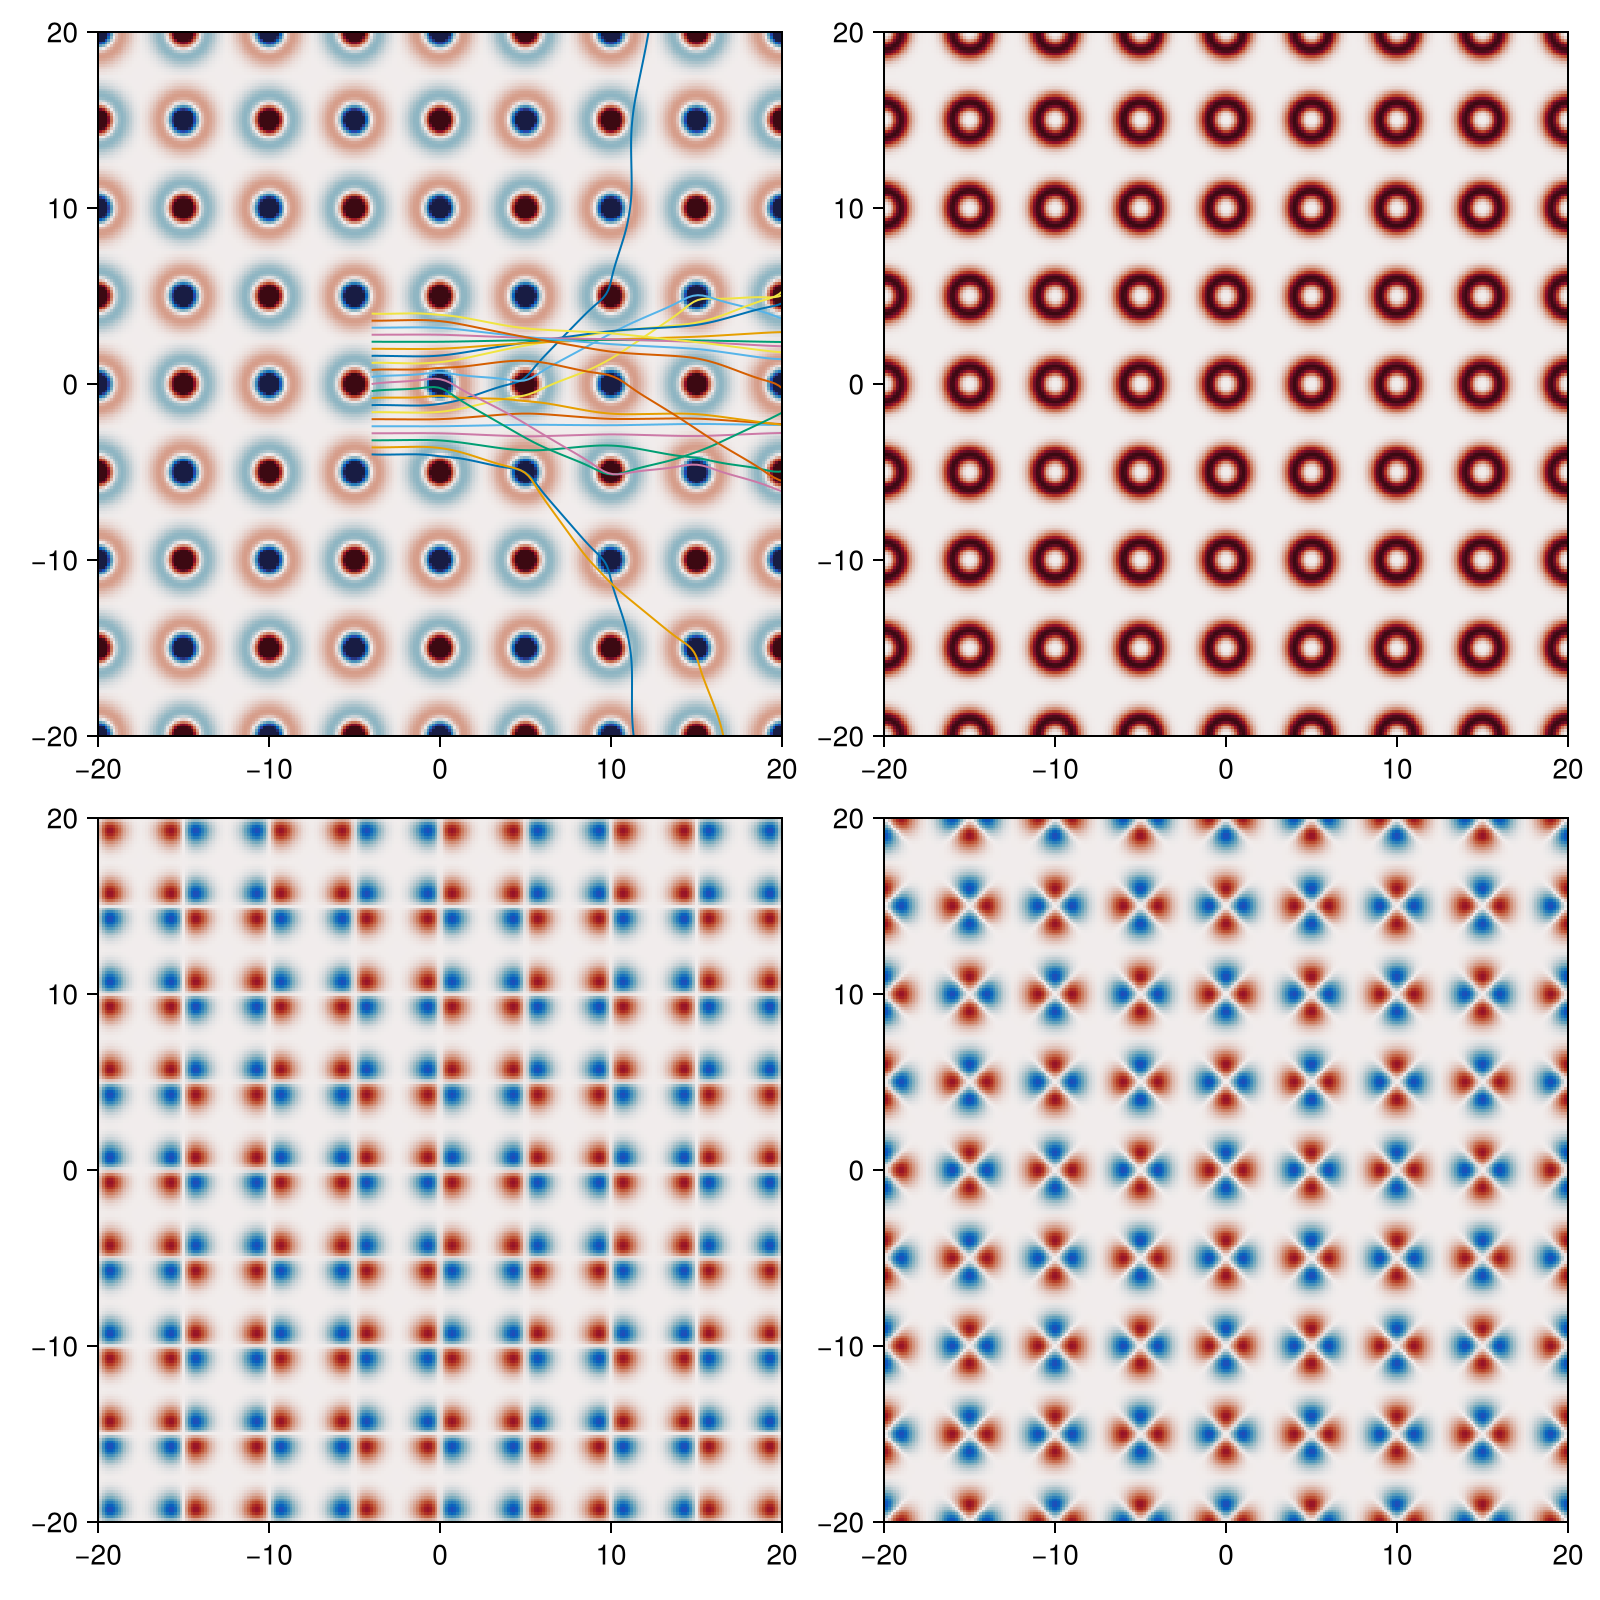

In [9]:
resolution = 256
range = (0:(resolution-1)) ./ (resolution - 1)
x = @. (2 * range - 1) * (5 * abs(initial_x0))
y = x'

ζ  = ∂v∂x.(x, y, 0, Ref(ode_params)) - ∂u∂y.(x, y, 0, Ref(ode_params))
σn = ∂u∂x.(x, y, 0, Ref(ode_params)) - ∂v∂y.(x, y, 0, Ref(ode_params))
σs = ∂v∂x.(x, y, 0, Ref(ode_params)) + ∂u∂y.(x, y, 0, Ref(ode_params))
σ = σn.^2 + σs.^2

fig = Figure(size=(800, 800))
ax_opts = (colormap=:balance, colorrange=(-1, 1))
ax11 = Axis(fig[1,1]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax11, x[:], y[:], ζ; ax_opts...)
ax12 = Axis(fig[1,2]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax12, x[:], y[:], σ; colormap=:amp)

ax21 = Axis(fig[2,1]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax21, x[:], y[:], σn; ax_opts...)
ax22 = Axis(fig[2,2]; limits=((x[1], x[end]), (y[1], y[end])))
heatmap!(ax22, x[:], y[:], σs; ax_opts...)

for idx=1:5:101
    lines!(ax11, x_sol[:,idx], y_sol[:,idx], linewidth=1)
end

fig